In [2]:
from collections import deque
from graphviz import Digraph
from graphviz import nohtml


class Node:
    """
    Simple binary search tree implementation.
    """

    def __init__(self, val, left=None, right=None):
        """
        Constructor of a node with optional left and right child nodes.
        l and r can be either numeric (payload) or Node instances.
        """
        self.val = val
        self.right = None
        self.left = None

        # create Node instances if necessary
        if right is not None:
            self.right = right if isinstance(right, Node) else self.__class__(right)
        if left is not None:
            self.left = left if isinstance(left, Node) else self.__class__(left)

    def __str__(self):
        return f'{repr(self.left)} <- {repr(self)} -> {repr(self.right)}'

    def __repr__(self):
        return f'[{self.val}]'

    def _children(self, empty=True):
        """
        Generator returning the children.
        If 'empty' is True - non-existing child nodes will be returned as 'None'.
        This should be a common interface method for trees.
        """
        if empty:
            yield self.left
            yield self.right
        else:
            if self.left:
                yield self.left
            if self.right:
                yield self.right

    def _preorder(self):  # Node-Left-Right
        yield self
        if self.left is not None:
            yield from self.left._preorder()
        if self.right is not None:
            yield from self.right._preorder()

    def _inorder(self):  # Left-Node-Right
        if self.left is not None:
            yield from self.left._inorder()
        yield self
        if self.right is not None:
            yield from self.right._inorder()

    def _postorder(self):  # Left-Right-Node
        if self.left is not None:
            yield from self.left._postorder()
        if self.right is not None:
            yield from self.right._postorder()
        yield self

    def _breadth_first(self):
        q = deque([self])
        try:
            while True:
                n = q.popleft()
                for c in n._children(empty=False):
                    q.append(c)
                yield n
        except IndexError:
            pass

    def _copy(self, node):
        self.val = node.val
        self.left = node.left
        self.right = node.right

    @property
    def node_count(self):
        if self.is_leaf:
            return 1
        return sum(c.node_count for c in self._children(empty=False)) + 1

    @property
    def depth(self):
        if self.is_leaf:
            return 0
        return max(c.depth for c in self._children(empty=False)) + 1

    @property
    def width(self):
        current_layer = [self]
        res = 1
        
        while len(current_layer) > 0:
            next_layer = []
            for n in current_layer:
                next_layer.extend(n._children(empty=False))
            res = max(res, len(next_layer))
            current_layer = next_layer
        return res
    
    @property
    def is_balanced(self):
        if self.is_leaf:
            return True
        if all(self._children()):  # all children are present
            return all((c.is_balanced for c in self._children())) and (abs(self.left.depth - self.right.depth) < 2)
        return max(c.depth for c in self._children(empty=False)) < 1

    @classmethod
    def build(cls, values, sort=True, allow_duplicates=True):
        if not allow_duplicates:
            values = set(values)
            
        if len(values) == 1:
            return cls(values[0])
        
        if len(values) == 2:
            return cls(max(values), left=cls(min(values)))
        
        if sort:
            values = sorted(values)
        
        # mid-point element becomes the tree root
        root_idx = len(values) // 2
        return cls(
            values[root_idx],
            left=cls.build(values[:root_idx], sort=False),  # recurse the left (smaller) values
            right=cls.build(values[root_idx + 1:], sort=False),  # recurse the right values
        )

    def balance(self):
        values = [_.val for _ in self._inorder()]
        return self.build(values)

    def traverse(self, order='in', f=None):
        # Use traversal to execute a function 'f' on all elements of the tree.  
        f = f or print
        if order == 'in':
            nodes = self._inorder()
        elif order == 'pre':
            nodes = self._preorder()
        elif order == 'post':
            nodes = self._postorder()
        elif order == 'bf':
            nodes = self._breadth_first()
        else:
            raise ValueError(f'Unknown traversal order: "{order}".')
        for n in nodes:
            f(n)

    def insert(self, val):
        node = val if isinstance(val, Node) else self.__class__(val)
        if node.val > self.val:
            if self.right is None:
                self.right = node
            else:
                self.right.insert(node)
        elif node.val < self.val:
            if self.left is None:
                self.left = node
            else:
                self.left.insert(node)
        else:  # val == self.val
            print(f'Node with value "{node.val}" is already in the tree.')
            return self
        return node

    def search(self, val):
        """
        Search for a node in the tree by its value or by the Node itself.
        """
        is_node = isinstance(val, Node)
        key = val if not is_node else val.val

        if (is_node and self == val) or (not is_node and val == self.val):
            return self
        if key > self.val and self.right is not None:
            return self.right.search(val)
        elif key < self.val and self.left is not None:
            return self.left.search(val)
        return None

    @property
    def is_leaf(self):
        return not any(self._children())

    def is_present(self, val):
        return self.search(val) is not None

    def parent_of(self, node):
        if node == self:
            return None
        if (self.left and node == self.left) or (self.right and node == self.right):
            return self
        if (node.val < self.val and self.left is None) or (node.val > self.val and self.right is None):
            raise ValueError(f'Node "{node}" not in the tree on parent_of().')
        if node.val < self.val:
            return self.left.parent_of(node)
        else:
            return self.right.parent_of(node)

    def delete(self, val):

        def _swap_nodes(parent, child_node, new_child_node):
            if parent.left == child_node:
                parent.left = new_child_node
            elif parent.right == child_node:
                parent.right = new_child_node

        to_delete = self.search(val)
        assert to_delete is not None, f'Value "{val}" not found on delete.'
        parent = self.parent_of(to_delete)

        # case 1: deleting a leaf
        if to_delete.is_leaf:
            _swap_nodes(parent, to_delete, None)
            del to_delete

        # case 2: only one child of 'to_delete' exists
        elif to_delete.left is not None and to_delete.right is None:
            if parent is not None:  # not deleting the root
                _swap_nodes(parent, to_delete, to_delete.left)
                del to_delete
            else:  # deleting the root, so just make a copy
                self._copy(to_delete.left)

        elif to_delete.left is None and to_delete.right is not None:
            if parent is not None:
                _swap_nodes(parent, to_delete, to_delete.right)
                del to_delete
            else:
                self._copy(to_delete.right)

        # case 3: 2 children of 'to_delete' are present
        elif to_delete.left is not None and to_delete.right is not None:
            ordered_nodes = to_delete._inorder()
            for n in ordered_nodes:  # skip until this None
                if n == to_delete:
                    break
            replacement = next(ordered_nodes)  # must be present as this is inorder with 2 child nodes
            replacement_val = replacement.val  # save temporarily
            self.delete(replacement)
            to_delete.val = replacement_val

    def draw(self):
        nodes, l_edges, r_edges = list(), set(), set()

        def _build_graph(n):
            if n not in nodes:
                nodes.append(n)
                if n.left is not None:
                    l_edges.add((n, n.left))
                    _build_graph(n.left)
                if n.right is not None:
                    r_edges.add((n, n.right))
                    _build_graph(n.right)

        _build_graph(self)
        dot = Digraph(
            'g',
            node_attr={
                'shape': 'record',
                'height': '.1',
            },
        )
        for n in nodes:
            dot.node(
                str(id(n)),
                nohtml(f'<f0>|<f1> {repr(n)} |<f2>'),
            )
        for n1, n2 in l_edges:
            dot.edge(
                str(id(n1)) + ':f0',
                str(id(n2)) + ':f1',
            )
        for n1, n2 in r_edges:
            dot.edge(
                str(id(n1)) + ':f2',
                str(id(n2)) + ':f1',
            )
        return dot
    
    def info(self, draw=True):
        print(f'The tree has {self.node_count} nodes in {self.depth+1} layer(s). It\'s width is {self.width}.\n' +
              f'The tree is {"" if self.is_balanced else "not "}balanced.')
        if draw:
            return self.draw()

The tree has 10 nodes in 5 layer(s). It's width is 3.
The tree is not balanced.


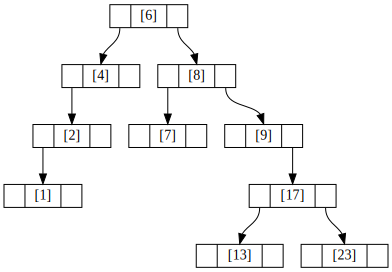

In [3]:
n1=Node(1)
n2=Node(2, left=n1)
n4=Node(4, left=n2)
n7=Node(7)
n9=Node(9)
n8=Node(8, left=n7, right=n9)
n6=Node(6, left=n4, right=n8)
n6.insert(Node(17))
n6.insert(23)
n6.insert(Node(13))
n6.info()

The tree has 9 nodes in 4 layer(s). It's width is 3.
The tree is not balanced.


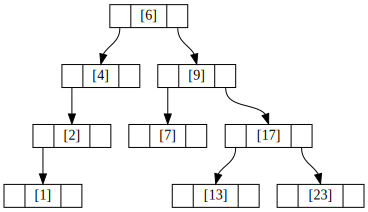

In [4]:
n6.delete(8)
n6.info()

The tree has 9 nodes in 4 layer(s). It's width is 4.
The tree is balanced.


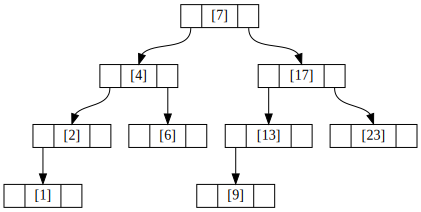

In [5]:
n6=n6.balance()
n6.info()

The tree has 10 nodes in 5 layer(s). It's width is 3.
The tree is not balanced.


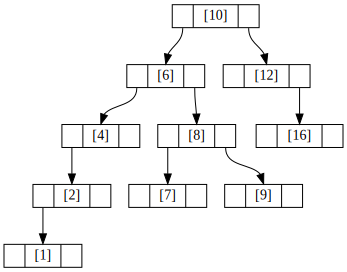

In [6]:
t1=Node(10)
t1.insert(6)
t1.insert(4)
t1.insert(2)
t1.insert(1)
t1.insert(8)
t1.insert(7)
t1.insert(9)
t1.insert(12)
t1.insert(16)
t1.info()

The tree has 9 nodes in 5 layer(s). It's width is 3.
The tree is not balanced.


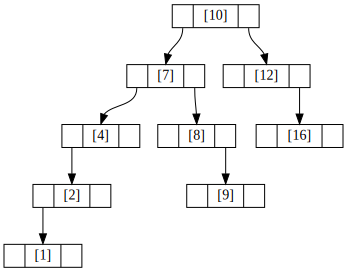

In [7]:
t1.delete(6)
t1.info()

The tree has 15 nodes in 9 layer(s). It's width is 3.
The tree is not balanced.


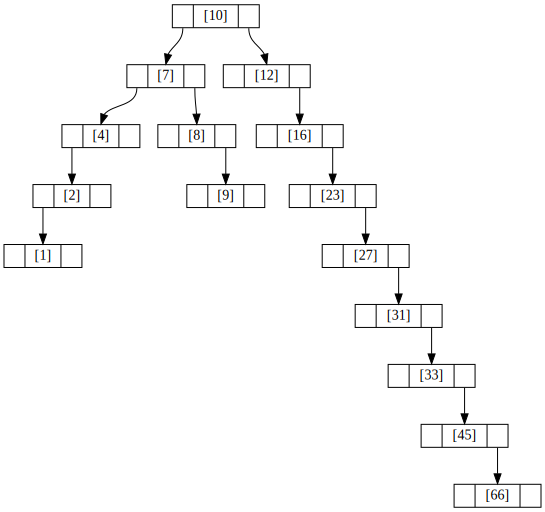

In [8]:
t1.insert(23); t1.insert(27);t1.insert(31); t1.insert(33);t1.insert(45); t1.insert(66)
t1.info()

In [9]:
vals = [1,2,4,6,7,8,9,13,17,23]
t2 = Node.build(vals)

The tree has 10 nodes in 4 layer(s). It's width is 4.
The tree is balanced.


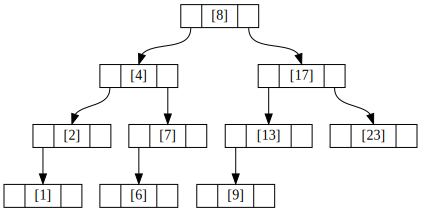

In [10]:
t2.info()

In [11]:
import string 

# From "As You Like It" by W. Shakespear
with open('shakespear.txt', 'r') as f:
    text=' '.join(f.readlines())
    text=text.replace('\n', ' ').lower().translate(str.maketrans('', '', string.punctuation)).replace('  ',' ')

In [12]:
words=text.split(' ')

tt=Node.build(words, allow_duplicates=False)
tt.info()

The tree has 981 nodes in 10 layer(s). It's width is 470.
The tree is balanced.
